In [1]:
import os
import yaml
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from pathlib import Path
from filetrials import FileTrials, space_eval
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping

# Import hyperopt modules
from hyperopt import hp, fmin, tpe

%matplotlib inline

In [2]:
# Fix the seeds for reproducible results
tf.random.set_seed(1234)
np.random.seed(5678)

In [78]:
current_path = Path().absolute()
hyperopt_path = current_path
fits_path = current_path / "fits"
fits_path.mkdir(exist_ok=True)
data_path = current_path / "data"

In [4]:
# load runcard with parameters
def load_runcard(filename):
    with open(f"{current_path}/" + filename, "r") as file:
        input_params = yaml.safe_load(file)
    return input_params

In [5]:
def split_trval(x_data, y_data, y_err_stat, y_err_sys, perc = 0.3):
    size_val = round(x_data.shape[0]*perc)
    idx = np.random.choice(np.arange(1, x_data.shape[0]-1, 2), size_val, replace=False)
    x_val = x_data[idx]
    y_val = y_data[idx]
    y_val_err_stat = y_err_stat[idx]
    y_val_err_sys = y_err_sys[idx]
    
    x_tr = np.delete(x_data, idx, axis = 0)
    y_tr = np.delete(y_data, idx)
    y_tr_err_stat = np.delete(y_err_stat, idx)
    y_tr_err_sys = np.delete(y_err_sys, idx)
    
    return x_tr, y_tr, y_tr_err_stat, y_tr_err_sys, x_val, y_val, y_val_err_stat, y_val_err_sys

In [59]:
def load_data(runcard):
    filenames = os.listdir(f"{data_path}")

    x_sep_data = []
    y_sep_data = []
    y_err_sep = []

    for i, filename in enumerate(filenames):
        with open(f"{data_path}/" + filename, "r") as file:
            input_data = yaml.safe_load(file)

        x = input_data["x"]
        Q2 = np.array(input_data["Q2"])
        F_2 = np.array(input_data["F_2"])
        F_2_err_stat = np.array(input_data["F_2_err_stat"])
        F_2_err_sys = np.array(input_data["F_2_err_sys"])

        if runcard["Q2_cut"] != None:
            Q2_mask = np.where(Q2 < runcard["Q2_cut"])
            Q2 = Q2[Q2_mask]
            F_2 = F_2[Q2_mask]
            F_2_err_stat = F_2_err_stat[Q2_mask]
            F_2_err_sys = F_2_err_sys[Q2_mask]

        if i == 0:
            x_data = np.zeros((len(Q2), 2))
            x_data[:, 0] = x
            x_data[:, 1] = Q2
            y_data = F_2
            x_sep_data.append(x_data)
            y_sep_data.append(y_data)
            y_err_sep.append(F_2_err_stat+F_2_err_sys)
            y_err_stat = F_2_err_stat
            y_err_sys = F_2_err_sys
            
            if x_data.shape[0] >= 3:
                x_tr, y_tr, y_tr_err_stat, y_tr_err_sys, x_val, y_val, y_val_err_stat, y_val_err_sys = split_trval(x_data, y_data, y_err_stat, y_err_sys, perc=runcard["validation_size"])
                #import pdb;pdb.set_trace()
                val = True
            else:
                x_tr = x_data
                y_tr = y_data
                y_tr_err_stat = y_err_stat
                y_tr_err_sys = y_err_sys
                val = False
        else:
            x_data_new = np.zeros((len(Q2), 2))
            x_data_new[:, 0] = x
            x_data_new[:, 1] = Q2
            y_data_new = F_2
            y_err_stat_new = F_2_err_stat
            y_err_sys_new = F_2_err_sys
            
            
            if x_data_new.shape[0] >= 3:
                x_tr_new, y_tr_new, y_tr_err_stat_new, y_tr_err_sys_new, x_val_new, y_val_new, y_val_err_stat_new, y_val_err_sys_new = split_trval(
                    x_data_new, y_data_new, y_err_stat_new, y_err_sys_new, perc=runcard["validation_size"]
                )
                if val:
                    x_val = np.concatenate([x_val, x_val_new], axis=0)
                    y_val = np.concatenate([y_val, y_val_new], axis=0)
                    y_val_err_stat = np.concatenate([y_val_err_stat, y_val_err_stat_new], axis=0)
                    y_val_err_sys = np.concatenate([y_val_err_sys, y_val_err_sys_new], axis=0)
                else:
                    x_val = x_val_new
                    y_val = y_val_new
                    y_val_err_stat = y_val_err_stat_new
                    y_val_err_sys = y_val_err_sys_new
                    val = True
                
            else:
                x_tr_new = x_data_new
                y_tr_new = y_data_new
                y_tr_err_stat_new = y_err_stat_new
                y_tr_err_sys_new = y_err_sys_new

            x_tr = np.concatenate([x_tr, x_tr_new], axis=0)
            y_tr = np.concatenate([y_tr, y_tr_new], axis=0)
            y_tr_err_stat = np.concatenate([y_tr_err_stat, y_tr_err_stat_new], axis=0)
            y_tr_err_sys = np.concatenate([y_tr_err_sys, y_tr_err_sys_new], axis=0)
            
            y_err_stat = np.concatenate([y_err_stat, y_err_stat_new], axis=0)
            y_err_sys = np.concatenate([y_err_sys, y_err_sys_new], axis=0)
            x_sep_data.append(x_data_new)
            y_sep_data.append(y_data_new)
            y_err_sep.append(F_2_err_stat+F_2_err_sys)
            x_data = np.concatenate([x_data, x_data_new], axis=0)
            y_data = np.concatenate([y_data, y_data_new], axis=0)

    return {
        "x_tr": x_tr,
        "y_tr": y_tr,
        "y_tr_err_stat": y_tr_err_stat,
        "y_tr_err_sys": y_tr_err_sys,
        "x_val": x_val,
        "y_val": y_val,
        "y_val_err_stat": y_val_err_stat,
        "y_val_err_sys": y_val_err_sys,
        "x_data": x_data,
        "y_data": y_data,
        "y_err_stat": y_err_stat,
        "y_err_sys": y_err_sys,
        "x_sep_data": x_sep_data,
        "y_sep_data": y_sep_data,
        "y_err_sep": y_err_sep,
    }

In [39]:
def compute_covmat(data_dict):
    covmat_tr = np.zeros((data_dict["y_tr"].shape[0], data_dict["y_tr"].shape[0]))
    for i in range(data_dict["y_tr"].shape[0]):
        for j in range(data_dict["y_tr"].shape[0]):
            covmat_tr[i, j] = (
                data_dict["y_tr_err_sys"][i] * data_dict["y_tr_err_sys"][j]
                + data_dict["y_tr"][i] * data_dict["y_tr"][j]
            )
            if i == j:
                covmat_tr[i, j] += data_dict["y_tr_err_stat"][i] ** 2
                
    covmat_val = np.zeros((data_dict["y_val"].shape[0], data_dict["y_val"].shape[0]))
    for i in range(data_dict["y_val"].shape[0]):
        for j in range(data_dict["y_val"].shape[0]):
            covmat_val[i, j] = (
                data_dict["y_val_err_sys"][i] * data_dict["y_val_err_sys"][j]
                + data_dict["y_val"][i] * data_dict["y_val"][j]
            )
            if i == j:
                covmat_val[i, j] += data_dict["y_val_err_stat"][i] ** 2
    
    return {"tr": covmat_tr, "val": covmat_val}

In [40]:
def chi2_with_covmat(covmat, ndata):
    inverted_tr = np.linalg.inv(covmat["tr"])
    inverted_val = np.linalg.inv(covmat["val"])
    ndata_tr = ndata["tr"]
    ndata_val = ndata["val"]
    # Convert numpy array into tensorflow object
    invcovmat_tr = K.constant(inverted_tr)
    invcovmat_val = K.constant(inverted_val)

    def custom_loss(y_true, y_pred):
        # (yt - yp) * covmat * (yt - yp)
        tmp = y_true - y_pred
        import pdb; pdb.set_trace()
        try:
            tmp = y_true - y_pred
            right_dot = tf.tensordot(invcovmat_val, K.transpose(tmp), axes=1)
            return tf.tensordot(tmp, right_dot, axes=1) / ndata_val
        
        except:
            right_dot = tf.tensordot(invcovmat_tr, K.transpose(tmp), axes=1)
            return tf.tensordot(tmp, right_dot, axes=1) / ndata_tr
        

    return custom_loss

In [41]:
def model_trainer(data_dict, runcard, **hyperparameters):
    # Collect the values for the hyperparameters
    optimizer = hyperparameters.get("optimizer", "adam")
    activation = hyperparameters.get("activation", "relu")
    epochs = hyperparameters.get("epochs", 10)
    nb_layers = hyperparameters.get("nb_layers", (2, {'units_layer_1_2': 64, 'units_layer_2_2': 32}))
    
    layers = list(nb_layers[1].keys())
    nb_units_1 = nb_layers[1][layers[0]]

    # Construct the model
    model = Sequential()
    model.add(Dense(units=nb_units_1, activation=activation, input_shape=[2]))
    
    if nb_layers[0] > 1:
        for layer in layers[1:]:
            model.add(Dense(units=nb_layers[1][layer], activation=activation))
    
    # output layer
    model.add(Dense(units=1, activation="linear"))

    # Compile the Model as usual
    ndata = {"tr": data_dict["y_tr"].shape[0], "val": data_dict["y_val"].shape[0]}
    covmat = compute_covmat(data_dict)
    #model.compile(loss=chi2_with_covmat(covmat, ndata), optimizer=optimizer, metrics=["accuracy"])
    model.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])

    # Callbacks for Early Stopping
    ES = EarlyStopping(
        monitor="val_loss",
        mode="min",
        verbose=0,
        patience=10,
        restore_best_weights=True,
    )

    # Fit the Model as usual
    model.fit(
        data_dict["x_tr"],
        data_dict["y_tr"],
        validation_data=(data_dict["x_val"], data_dict["y_val"]),
        epochs=epochs,
        verbose=0,
        callbacks=[ES],
    )

    # Evaluate the Model on the test. Note that this will be the
    # parameter to hyperoptimize. If one wants, one could use x/y_tr.
    # This might be ideal if one have very small number of datapoints
    scores = model.evaluate(data_dict["x_val"], data_dict["y_val"], verbose=0)
    # Return the value of the validation loss
    return model, scores[0]

In [42]:
def construct_layers_dict(runcard):
    layers_list = []
    nb_units_per_layer = runcard["nb_units_per_layer"]
    for n in runcard["layers_choices"]:
        layer_dict = {}
        for i in range(1, n+1):
            key = f"units_layer_{i}_{n}"
            layer_dict[f"units_layer_{i}"] = hp.quniform(key, nb_units_per_layer["min"], nb_units_per_layer["max"], nb_units_per_layer["samples"])
        layers_list.append((n, layer_dict))
    return hp.choice("nb_layers", layers_list)

In [43]:
def define_hyperspace(runcard):
    learning_rate_choices = runcard["learning_rate_choices"]
    activation = hp.choice("activation", runcard["activation_choices"])
    optimizer = hp.choice("optimizer", runcard["optimizer_choices"])
    epochs = hp.choice("epochs", runcard["epochs_choices"])
    initializer = hp.choice("initializer", runcard["initializer_choices"])
    learning_rate = hp.loguniform("learning_rate", float(learning_rate_choices["min"]), float(learning_rate_choices["max"]))
    nb_layers = construct_layers_dict(runcard)
    
    return {
        "activation": activation,
        "optimizer": optimizer,
        "epochs": epochs,
        "initializer": initializer,
        "learning_rate": learning_rate,
        "nb_layers": nb_layers
    }

In [44]:
def perform_hyperopt(data_dict, runcard):
    hyperspace = define_hyperspace(runcard)

    # Define the hyperoptimization function
    def hyper_function(hyperspace_dict):
        _, val_loss = model_trainer(data_dict, runcard, **hyperspace_dict)
        return {"loss": val_loss, "status": "ok"}

    trials = FileTrials(hyperopt_path, parameters=hyperspace)
    best = fmin(
        fn=hyper_function,
        space=hyperspace,
        verbose=1,
        max_evals=runcard["nb_trials"],
        algo=tpe.suggest,
        trials=trials,
    )
    # Save the best hyperparameters combination in order to return it later
    best_setup = space_eval(hyperspace, best)
    # Write the output of the best into a file
    with open(f"{hyperopt_path}/best_hyperparameters.yaml", "w") as file:
        yaml.dump(best_setup, file, default_flow_style=False)
    # Write the all the history of the hyperopt into a file
    with open(f"{hyperopt_path}/hyperopt_history.pickle", "wb") as histfile:
        pickle.dump(trials.trials, histfile)
    return best_setup

In [46]:
runcard = load_runcard("runcard.yaml")

In [66]:
data_dict = load_data(runcard)

In [16]:
best_params = perform_hyperopt(data_dict, runcard)

  0%|                                     | 0/2 [00:00<?, ?trial/s, best loss=?]

2022-04-25 14:26:14.382335: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-25 14:26:14.385519: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 14:26:14.583712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-25 14:26:14.617771: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


100%|██████████| 2/2 [00:08<00:00,  4.11s/trial, best loss: 0.07724768668413162]


In [45]:
def plot_constant_x(best_model, data_dict):
    # loop over x values
    for i in range(len(data_dict["x_sep_data"])):
        x = data_dict["x_sep_data"][i]
        y = data_dict["y_sep_data"][i]
        x_grid = np.linspace(x[0], x[-1], 100)
        y_pred = best_model(x_grid)
        
        fig, ax = plt.subplots(1, 1) 
        ax.plot(x_grid[:, 1], y_pred, color="red", label="Prediction")
        ax.scatter(x[:, 1], y, color="blue", label="Data")
        ax.legend()
        ax.set_xlabel("$Q^2$ [GeV$^2$]")
        ax.set_ylabel("$F_2$")
        ax.set_title(f"Prediction of $F_2$ at $x={x[0,0]}$")
        plt.show()
        plt.savefig(f"{fits_path}/FIT_{x[0,0]}.png")
        ax.clear()

In [17]:
best_model,_ = model_trainer(data_dict, runcard, **best_params)

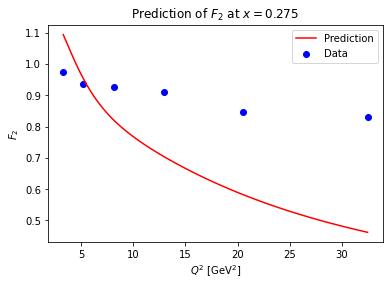

<Figure size 432x288 with 0 Axes>

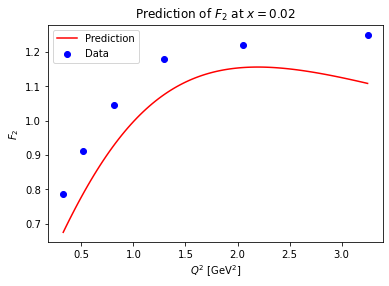

<Figure size 432x288 with 0 Axes>

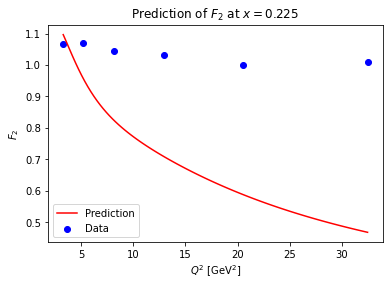

<Figure size 432x288 with 0 Axes>

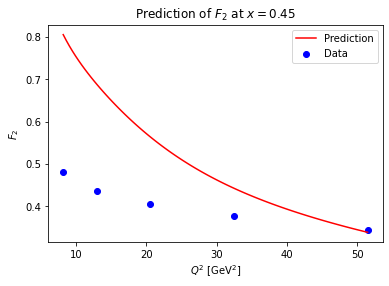

<Figure size 432x288 with 0 Axes>

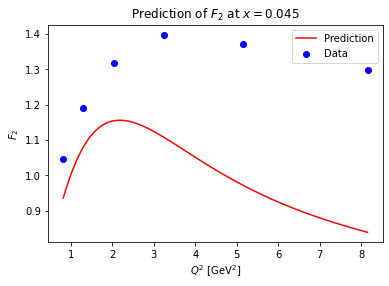

<Figure size 432x288 with 0 Axes>

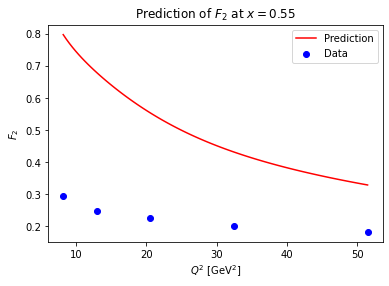

<Figure size 432x288 with 0 Axes>

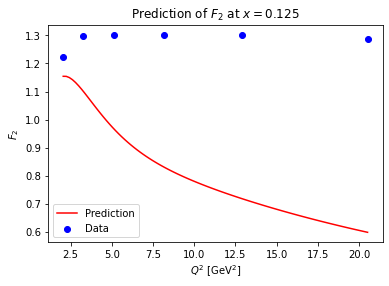

<Figure size 432x288 with 0 Axes>

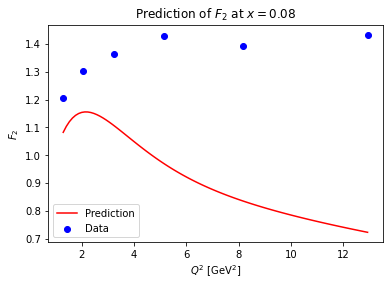

<Figure size 432x288 with 0 Axes>

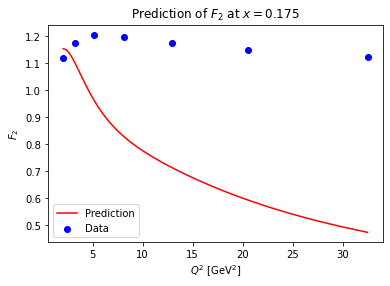

<Figure size 432x288 with 0 Axes>

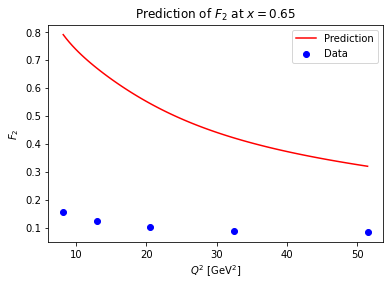

<Figure size 432x288 with 0 Axes>

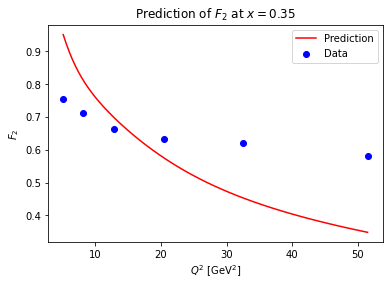

<Figure size 432x288 with 0 Axes>

In [18]:
plot_constant_x(best_model, data_dict)

In [52]:
def create_replicas(data_dict, runcard):
    n_rep = runcard["nb_replicas"]
    
    # training set
    y_dist_tr = np.zeros((n_rep, data_dict["y_tr"].shape[0]))
    for i, mean in enumerate(data_dict["y_tr"]):
        y_dist_tr[:, i] = np.random.normal(
            loc=mean,
            scale=(data_dict["y_tr_err_stat"][i] + data_dict["y_tr_err_sys"][i]),
            size=n_rep,
        )
       
    # validation set
    y_dist_val = np.zeros((n_rep, data_dict["y_val"].shape[0]))
    for i, mean in enumerate(data_dict["y_val"]):
        y_dist_val[:, i] = np.random.normal(
            loc=mean,
            scale=(data_dict["y_val_err_stat"][i] + data_dict["y_val_err_sys"][i]),
            size=n_rep,
        )
    
    return y_dist_tr, y_dist_val

In [73]:
def fit_replicas(data_dict, runcard):
    y_dist_tr, y_dist_val = create_replicas(data_dict, runcard)
    models = []
    
    for y_tr, y_val in zip(y_dist_tr, y_dist_val):
        new_data_dict = data_dict.copy()
        new_data_dict["y_tr"] = y_tr
        new_data_dict["y_val"] = y_val
        best_model,_ = model_trainer(data_dict, runcard, **best_params)
        models.append(best_model)
    
    return models

In [76]:
def plot_with_reps(models, data_dict):
    # loop over x values
    for x,y,y_err in zip(data_dict["x_sep_data"],data_dict["y_sep_data"],data_dict["y_err_sep"]):
        x_grid = np.linspace(x[0], x[-1], 100)
        
        # loop over replicas
        y_pred = []
        for model in models:
            y_pred.append(model.predict(x_grid))
        
        # comput mean and errorbands
        p1_high = np.nanpercentile(y_pred,84,axis=0)
        p1_low = np.nanpercentile(y_pred,16,axis=0)
        p1_mid = (p1_high + p1_low )/2.
        p1_error = (p1_high - p1_low )/2.
        
        p1_mid = p1_mid.reshape(-1)
        p1_error = p1_error.reshape(-1)
        
        # plot
        fig, ax = plt.subplots(1, 1) 
        ax.errorbar(x[:, 1], y, yerr=y_err, label = "Data", fmt="ko", capsize=5)
        ax.fill_between(x_grid[:, 1], y1=p1_mid-p1_error, y2=p1_mid+p1_error, color="red", edgecolor="red", label="Prediction", alpha=0.25)
        ax.plot(x_grid[:, 1], p1_mid, color="red", linestyle="dashed")
        ax.legend()
        ax.set_xlabel("$Q^2$ [GeV$^2$]")
        ax.set_ylabel("$F_2$")
        ax.set_title(f"Prediction of $F_2$ at $x={x[0,0]}$")
        plt.show()
        plt.savefig(f"{fits_path}/FIT_{x[0,0]}.png")
        ax.clear()

In [74]:
models = fit_replicas(data_dict, runcard)

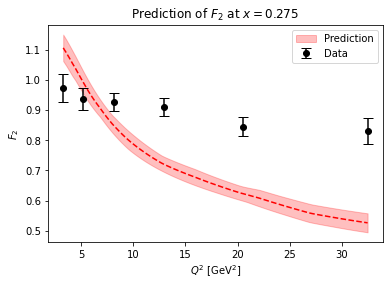

<Figure size 432x288 with 0 Axes>

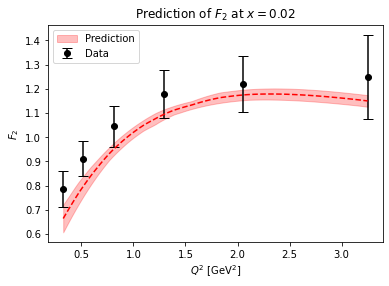

<Figure size 432x288 with 0 Axes>

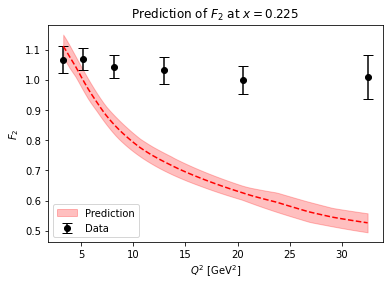

<Figure size 432x288 with 0 Axes>

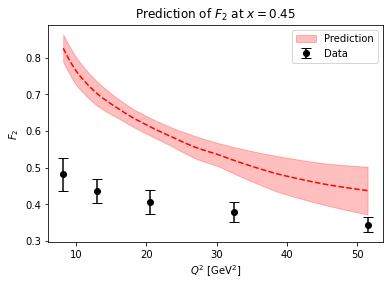

<Figure size 432x288 with 0 Axes>

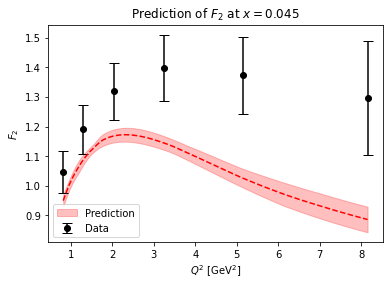

<Figure size 432x288 with 0 Axes>

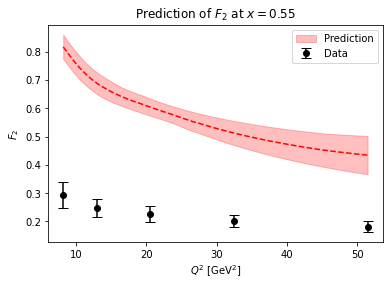

<Figure size 432x288 with 0 Axes>

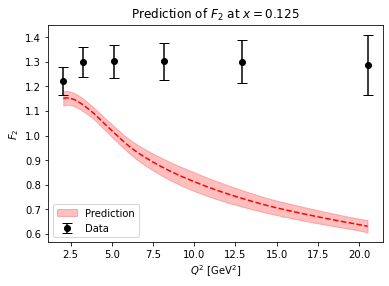

<Figure size 432x288 with 0 Axes>

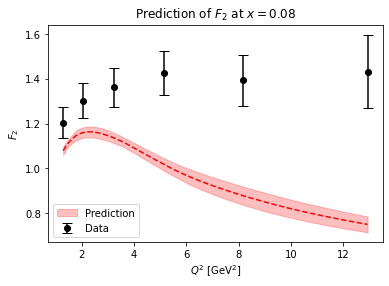

<Figure size 432x288 with 0 Axes>

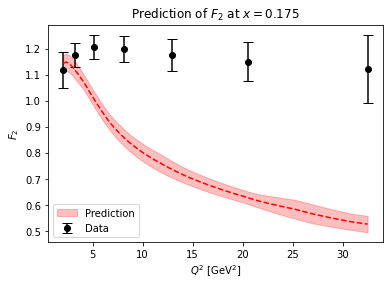

<Figure size 432x288 with 0 Axes>

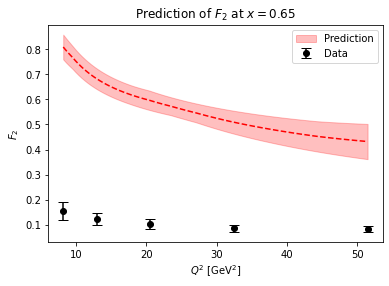

<Figure size 432x288 with 0 Axes>

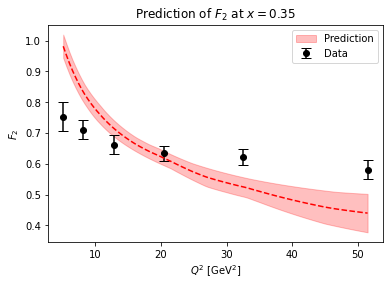

<Figure size 432x288 with 0 Axes>

In [77]:
plot_with_reps(models, data_dict)

Seperate scripts:
- hyperopt (combine with filetrials?)
- training (option replicas)
- plotting